In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [6]:

def read_graph_from_gml(file):
    G = nx.read_gml(file)
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
    nx.set_node_attributes(G, pos, name='pos')
    return G

def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
    node1, node2 = edge
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(R * c, 5)

In [ ]:
# import geopandas
# states = geopandas.read_file('data/usa-states-census-2014.shp')
# type(states)

In [7]:
G = read_graph_from_gml("ESnet2.gml")
pos_list = nx.get_node_attributes(G, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
max_dist = 100

orig_edges = np.copy(G.edges())
c_edge = 0
c_rep = 0
weights = dict()
for edge in orig_edges:
    dist = compute_dist_lat_lon(edge,G)
    if dist > max_dist:
        n1, n2 = edge
        G.remove_edge(n1,n2)
        c_edge += 1
        n_rep = int(dist/max_dist)
        G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
        G.add_edge(n1,c_rep)
        weights[(n1,c_rep)] = dist/(n_rep+1)
        i_r = 0
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        G.add_edge(c_rep+n_rep-1,n2)
        weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
        i_r = n_rep -1
        pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
        for i_r in range(0,n_rep-1):
            G.add_edge(i_r+c_rep,i_r+c_rep+1)
            pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
            weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)
            
        c_rep += n_rep
    else:
        n1, n2 = edge
        weights[(n1,n2)] = dist
        
nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % max_dist,c_edge)
print("No. of aux. nodes=",c_rep)

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'

No. of modified edges longer than 100 km:  57
No. of aux. nodes= 292


True
7
602.3628
677.02788


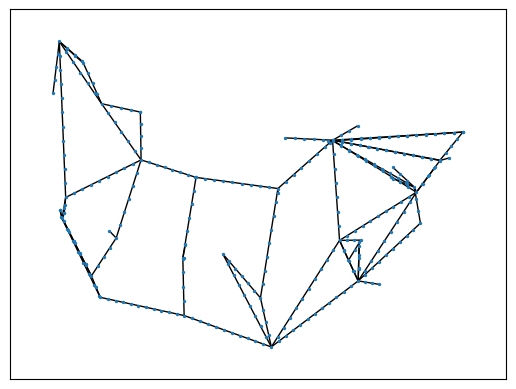

In [8]:
# print(G.nodes())
nx.draw_networkx(G,pos=pos_list,with_labels=False,node_size=2,font_size=8)
print(nx.has_path(G, source="SALT", target="DENV"))
print(nx.shortest_path_length(G, source="SALT", target="DENV"))
print(nx.shortest_path_length(G, source="SALT", target="DENV", weight="weight"))
print(nx.shortest_path_length(G, source="SLAC", target="GA", weight="weight"))


In [ ]:
# fig,ax = plt.subplots(figsize = (15,15))
# states.boundary.plot(ax = ax,linewidth=0.1,color="black")

fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.6)

plt.show()

In [4]:
# fig,ax = plt.subplots(figsize = (15,15))
# states.boundary.plot(ax = ax,linewidth=0.1,color="black")
import geopy.distance


fig,ax = plt.subplots(figsize = (20,10))
source_coords = (nodedata["SLAC"]["Longitude"],nodedata["SLAC"]["Latitude"])
destination_coords = (nodedata["GA"]["Longitude"],nodedata["GA"]["Latitude"])

for node, nodedata in G.nodes.items():
    coords_2 = (nodedata[node]["Longitude"],nodedata[node]["Latitude"])
    distance_from_source = geopy.distance.geodesic(source_coords, coords_2).km
    distance_from_destination = geopy.distance.geodesic(destination_coords, coords_2).km
    if distance_from_source<100 and distance_from_destination<100:
        print(node,nodedata)

ModuleNotFoundError: No module named 'geopy'